In [180]:
import sys 
sys.path.append('..//utils')
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from MiguelTK import *
import warnings
warnings.filterwarnings('ignore')

In [181]:
df = pd.read_csv('data/facturacion.csv')
df.head()

,fecha_de_factura,factura,codigo_de_stock,producto,cantidad,precio,id_del_cliente,ciudad
0,2021-12-05,537196,21811,CHRISTMAS HANGING HEART WITH BELL,1.0,1.25,c8a66fe3,Lleida
1,2020-12-16,539294,47574A,ENGLISH ROSE SCENTED HANGING FLOWER,1.0,4.25,7d08cdc9,Madrid
2,2020-10-18,571714,84951A,SET OF 4 PISTACHIO LOVEBIRD COASTER,NaN,NaN,df301f04,Oviedo
3,2022-09-08,566060,82484,WOOD BLACK BOARD ANT WHITE FINISH,2.0,16.63,a70cf1ee,Valencia
4,2022-12-06,537237,22208,WOOD STAMP SET THANK YOU,3.0,3.36,b0e56ea7,Alicante


In [182]:
df.dropna(subset='id_del_cliente',inplace=True)
df['fecha_de_factura'] = pd.to_datetime(df['fecha_de_factura'])

In [183]:
df.ciudad.unique()

array(['Lleida', 'Madrid', 'Oviedo', 'Valencia', 'Alicante', 'Móstoles',
       'Girona', 'Avilés', 'Castellón', 'Alcalá de Henares', 'Barcelona',
       'Gijón', 'madrid', 'Madrid '], dtype=object)

In [184]:
df['ciudad'] = (
    df
    ['ciudad']
    .str.lstrip()
    .str.rstrip()
    .str.upper()
)

In [185]:
df.ciudad.unique()

array(['LLEIDA', 'MADRID', 'OVIEDO', 'VALENCIA', 'ALICANTE', 'MÓSTOLES',
       'GIRONA', 'AVILÉS', 'CASTELLÓN', 'ALCALÁ DE HENARES', 'BARCELONA',
       'GIJÓN'], dtype=object)

In [186]:
customer_prof = pd.read_csv('data/customer.csv')[['Customer ID','Age','Gender','Subscription Status']]
df_integrado = pd.merge(
    df,
    customer_prof,
    how = 'inner',
    left_on = 'id_del_cliente',
    right_on = 'Customer ID'
).drop(columns='Customer ID')
df_integrado.head()

,fecha_de_factura,factura,codigo_de_stock,producto,cantidad,precio,id_del_cliente,ciudad,Age,Gender,Subscription Status
0,2021-12-05,537196,21811,CHRISTMAS HANGING HEART WITH BELL,1.0,1.25,c8a66fe3,LLEIDA,48,Male,Yes
1,2020-12-16,539294,47574A,ENGLISH ROSE SCENTED HANGING FLOWER,1.0,4.25,7d08cdc9,MADRID,29,Male,No
2,2020-10-18,571714,84951A,SET OF 4 PISTACHIO LOVEBIRD COASTER,NaN,NaN,df301f04,OVIEDO,41,Male,Yes
3,2022-09-08,566060,82484,WOOD BLACK BOARD ANT WHITE FINISH,2.0,16.63,a70cf1ee,VALENCIA,67,Female,No
4,2022-12-06,537237,22208,WOOD STAMP SET THANK YOU,3.0,3.36,b0e56ea7,ALICANTE,49,Male,No


In [187]:
df_integrado.rename(
    columns = {'Age':'age','Gender':'genero','Subscription Status':'suscripcion'},
    inplace = True
)

In [188]:
df_integrado['suscripcion'].unique()

array(['Yes', 'No'], dtype=object)

In [189]:
df_categoria = pd.read_csv('data/categoria_producto.csv')
df_categoria.head()

,Category,codigo_de_stock
0,Foodies,85123a
1,Moda,71053
2,Moda,84406B
3,Aventura,84029G
4,Tecnologia,84029E


In [190]:
df_integrado = pd.merge(
    df_integrado,
    df_categoria,
    how = 'inner',
    on = 'codigo_de_stock'
)
df_integrado.head()

,fecha_de_factura,factura,codigo_de_stock,producto,cantidad,precio,id_del_cliente,ciudad,age,genero,suscripcion,Category
0,2021-12-05,537196,21811,CHRISTMAS HANGING HEART WITH BELL,1.0,1.25,c8a66fe3,LLEIDA,48,Male,Yes,Moda
1,2021-12-05,537196,21811,CHRISTMAS HANGING HEART WITH BELL,1.0,1.25,c8a66fe3,LLEIDA,48,Male,Yes,Health & Wellness
2,2020-12-16,539294,47574A,ENGLISH ROSE SCENTED HANGING FLOWER,1.0,4.25,7d08cdc9,MADRID,29,Male,No,Tecnologia
3,2020-10-18,571714,84951A,SET OF 4 PISTACHIO LOVEBIRD COASTER,NaN,NaN,df301f04,OVIEDO,41,Male,Yes,Tecnologia
4,2022-09-08,566060,82484,WOOD BLACK BOARD ANT WHITE FINISH,2.0,16.63,a70cf1ee,VALENCIA,67,Female,No,Aventura


In [191]:
df_integrado['Category'].unique()

array(['Moda', 'Health & Wellness', 'Tecnologia', 'Aventura', 'Foodies'],
      dtype=object)

In [192]:
df = df_integrado

In [193]:
df['age_cat'] = pd.qcut(df['age'],5)

In [194]:
df['total'] = df['cantidad']*df['precio']

In [195]:
df['mes'] = df['fecha_de_factura'].dt.month.astype(str).str.zfill(2) + '/' + df['fecha_de_factura'].dt.year.astype(str)

In [196]:
for cat_var in ['ciudad','genero','suscripcion','Category','age_cat']:
    df[cat_var] = pd.Categorical(df[cat_var])

In [198]:
df = (
    df
    .query('cantidad > 0')
    .query('cantidad < cantidad.quantile(.95)')
    .query('precio < precio.quantile(.95)')
)

## Análisis exploratorio de los datos

In [199]:
num_vars = df.select_dtypes('number').melt()
num_vars.head()

,variable,value
0,cantidad,1.0
1,cantidad,1.0
2,cantidad,1.0
3,cantidad,3.0
4,cantidad,12.0


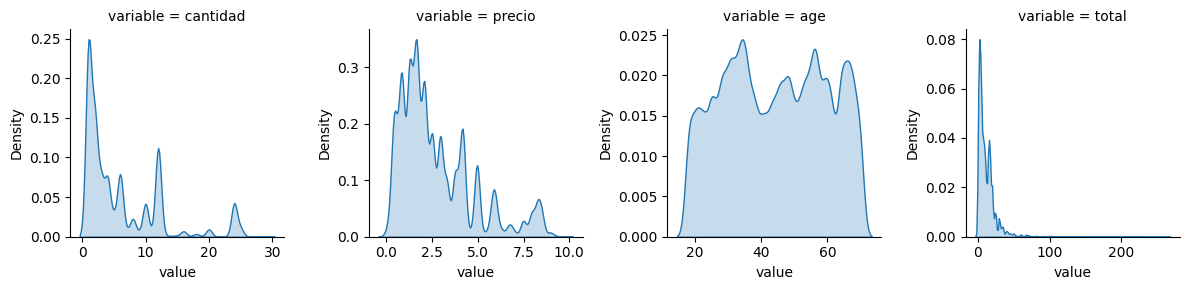

In [200]:
grid = sns.FacetGrid(num_vars,col='variable',sharex=False,sharey=False)
grid.map(sns.kdeplot,'value',fill=True)

In [201]:
cat_vars = df.select_dtypes('category').melt()
cat_vars.head()

,variable,value
0,ciudad,LLEIDA
1,ciudad,LLEIDA
2,ciudad,MADRID
3,ciudad,ALICANTE
4,ciudad,ALICANTE


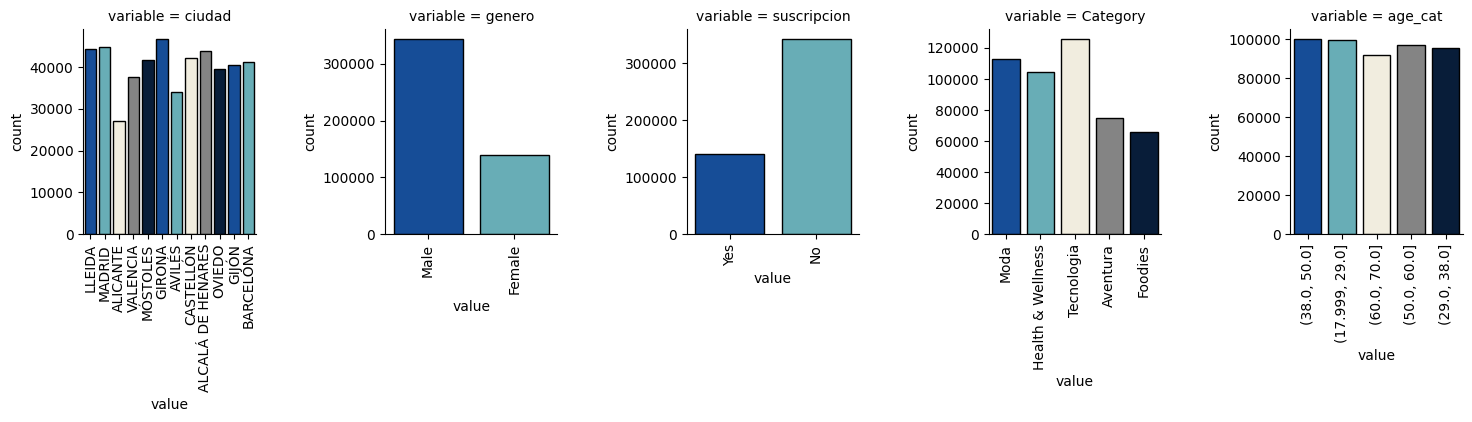

In [202]:
grid = sns.FacetGrid(cat_vars,col='variable',sharex=False,sharey=False)
grid.map(sns.countplot,'value',**kwargs)
grid.tick_params('x',rotation=90)

<Axes: xlabel='precio', ylabel='Density'>

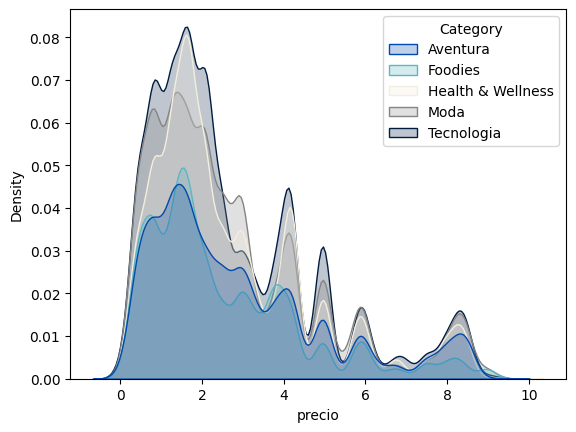

In [203]:
sns.kdeplot(
    data = df,
    x = 'precio',
    hue = 'Category',
    palette = palette,
    fill = True
)

## Análisis de cohortes

In [204]:
primera_compra = (
    df
    .groupby('id_del_cliente')
    ['fecha_de_factura']
    .transform('min')
)

In [205]:
cohort_month = primera_compra.dt.month
cohort_year = primera_compra.dt.year
df['mes_cohorte'] = cohort_month.astype(str).str.zfill(2) + '/' + cohort_year.astype(str)
month_diff = df['fecha_de_factura'].dt.month - cohort_month
year_diff = df['fecha_de_factura'].dt.year - cohort_year
df['cohort_index'] = year_diff * 12 + month_diff

In [206]:
df.head()

,fecha_de_factura,factura,codigo_de_stock,producto,cantidad,precio,id_del_cliente,ciudad,age,genero,suscripcion,Category,age_cat,total,mes,mes_cohorte,cohort_index
0,2021-12-05,537196,21811,CHRISTMAS HANGING HEART WITH BELL,1.0,1.25,c8a66fe3,LLEIDA,48,Male,Yes,Moda,"(38.0, 50.0]",1.25,12/2021,01/2020,23
1,2021-12-05,537196,21811,CHRISTMAS HANGING HEART WITH BELL,1.0,1.25,c8a66fe3,LLEIDA,48,Male,Yes,Health & Wellness,"(38.0, 50.0]",1.25,12/2021,01/2020,23
2,2020-12-16,539294,47574A,ENGLISH ROSE SCENTED HANGING FLOWER,1.0,4.25,7d08cdc9,MADRID,29,Male,No,Tecnologia,"(17.999, 29.0]",4.25,12/2020,01/2020,11
5,2022-12-06,537237,22208,WOOD STAMP SET THANK YOU,3.0,3.36,b0e56ea7,ALICANTE,49,Male,No,Moda,"(38.0, 50.0]",10.08,12/2022,01/2020,35
6,2021-05-08,552309,21094,SET/6 RED SPOTTY PAPER PLATES,12.0,0.85,4f289506,ALICANTE,64,Male,Yes,Tecnologia,"(60.0, 70.0]",10.20,05/2021,01/2020,16


### Agrupación por fechas de primera compra

In [207]:
cohortes_fecha = (
    df
    .pivot_table(
        index = 'mes_cohorte',
        columns = 'cohort_index',
        values = 'id_del_cliente',
        aggfunc = 'nunique'
    )
)
cohortes_fecha = cohortes_fecha.divide(cohortes_fecha[0],axis=0)
cohortes_fecha.head()

cohort_index,0,1,2,3,4,5,6,7,8,9,...,38,39,40,41,42,43,44,45,46,47
mes_cohorte,,,,,,,,,,,,,,,,,,,,,
01/2020,1.0,0.621928,0.714556,0.676749,0.737240,0.716446,0.695652,0.682420,0.799622,0.803403,...,0.724008,0.684310,0.744802,0.708885,0.712665,0.682420,0.809074,0.820416,0.886578,0.860113
01/2021,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
02/2020,1.0,0.643243,0.605405,0.697297,0.670270,0.632432,0.654054,0.783784,0.751351,0.832432,...,0.594595,0.691892,0.686486,0.648649,0.654054,0.767568,0.762162,0.821622,0.821622,NaN
02/2022,1.0,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
03/2020,1.0,0.495726,0.529915,0.538462,0.521368,0.452991,0.538462,0.632479,0.700855,0.692308,...,0.547009,0.538462,0.521368,0.495726,0.555556,0.641026,0.692308,0.675214,NaN,NaN


Text(0.5, 1.0, 'Número de clientes diferentes desde el primer mes de compra')

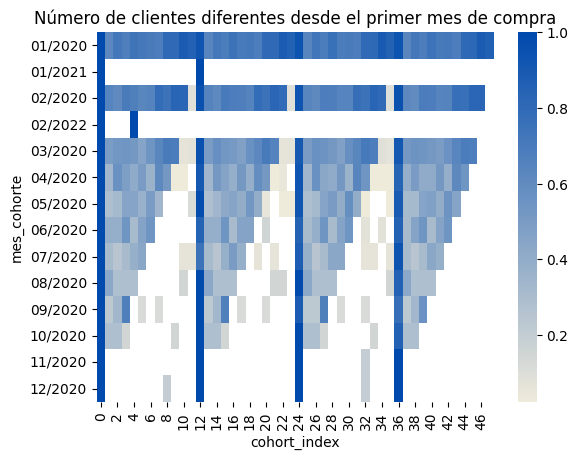

In [208]:
sns.heatmap(
    cohortes_fecha,
    cmap = cmap,
    center = 0,
    vmax = 1
)
plt.title('Número de clientes diferentes desde el primer mes de compra')

In [209]:
cohortes_fecha = (
    df
    .pivot_table(
        index = 'mes_cohorte',
        columns = 'cohort_index',
        values = 'id_del_cliente',
        aggfunc = 'count'
    )
)
cohortes_fecha = cohortes_fecha.divide(cohortes_fecha[0],axis=0)
cohortes_fecha.head()

cohort_index,0,1,2,3,4,5,6,7,8,9,...,38,39,40,41,42,43,44,45,46,47
mes_cohorte,,,,,,,,,,,,,,,,,,,,,
01/2020,1.0,0.527304,0.657808,0.576359,0.714928,0.692979,0.772048,0.622240,1.010842,1.280709,...,0.672220,0.564591,0.728018,0.662436,0.797699,0.633347,1.007140,1.260611,1.788576,1.283882
01/2021,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
02/2020,1.0,0.778922,0.555392,0.833333,0.908333,0.760784,0.908333,1.213725,1.255882,1.743137,...,0.555882,0.864216,0.857843,0.733333,0.892647,1.235294,1.282843,1.732353,1.392647,NaN
02/2022,1.0,NaN,NaN,NaN,0.500000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
03/2020,1.0,0.551367,0.544769,0.786051,0.707823,0.661640,0.795476,0.994345,1.705938,1.270500,...,0.566447,0.774741,0.773798,0.675778,0.760603,1.000943,1.632422,1.313855,NaN,NaN


Text(0.5, 1.0, 'Número de compras desde el primer mes de compra')

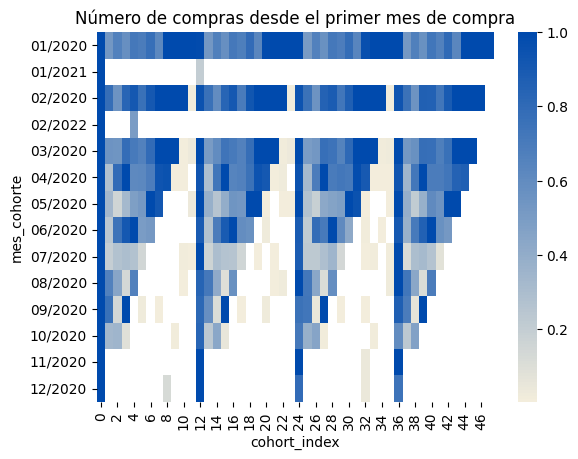

In [210]:
sns.heatmap(
    cohortes_fecha,
    cmap = cmap,
    center = 0,
    vmax = 1
)
plt.title('Número de compras desde el primer mes de compra')

In [211]:
cohortes_fecha = (
    df
    .pivot_table(
        index = 'mes_cohorte',
        columns = 'cohort_index',
        values = 'total',
        aggfunc = 'mean'
    )
)
cohortes_fecha = cohortes_fecha.divide(cohortes_fecha[0],axis=0)
cohortes_fecha.head()

cohort_index,0,1,2,3,4,5,6,7,8,9,...,38,39,40,41,42,43,44,45,46,47
mes_cohorte,,,,,,,,,,,,,,,,,,,,,
01/2020,1.0,1.111248,1.058618,1.041651,1.203921,1.095051,1.030715,1.226696,1.194017,1.065494,...,1.053989,1.042949,1.185967,1.099776,1.002645,1.175002,1.228558,1.092834,1.052598,1.075222
01/2021,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
02/2020,1.0,0.960376,0.993873,1.008434,0.959943,1.012881,1.047989,1.117807,1.027038,0.905882,...,0.951411,0.956893,0.967817,1.010609,1.019336,1.143920,1.069916,0.912784,1.019065,NaN
02/2022,1.0,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
03/2020,1.0,0.861339,1.191266,0.972480,0.979126,0.929317,0.969273,0.985457,0.883083,0.957605,...,1.194309,0.956285,0.824256,0.933888,0.980448,0.928204,0.818682,0.880438,NaN,NaN


Text(0.5, 1.0, 'Media del total de la factura')

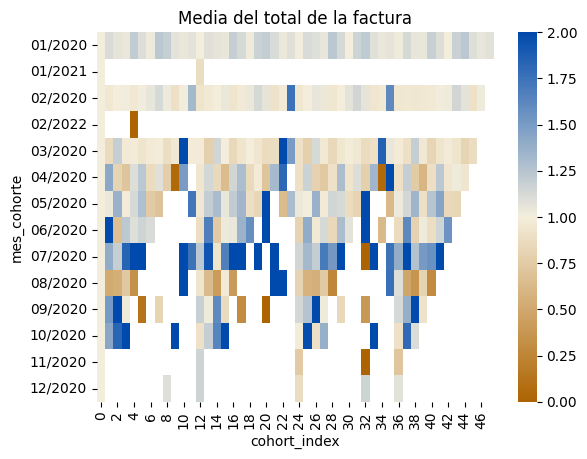

In [212]:
sns.heatmap(
    cohortes_fecha,
    cmap = cmap,
    center = 1,
    vmax = 2,
    vmin = 0
)
plt.title('Media del total de la factura')

AttributeError: Line2D.set() got an unexpected keyword argument 'aggfunc'

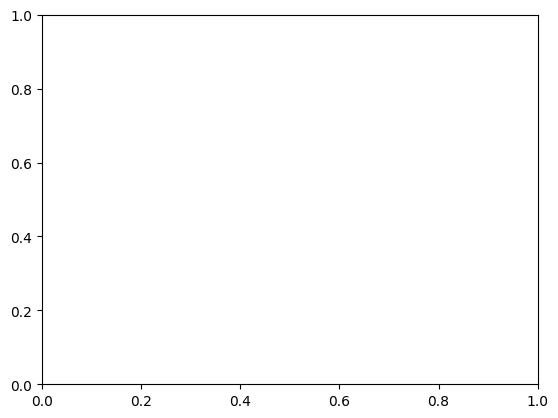

In [233]:
cohortes = (
    df
    .groupby(['mes','cohort_index','id_del_cliente','mes_cohorte'],as_index=False)
    .size()
)
sns.lineplot(
    data = cohortes,
    x = 'cohort_index',
    y = 'size',
    aggfunc = 'mean'
)
cohortes = cohortes.pivot_table(
    columns = 'cohort_index',
    index = 'mes_cohorte',
    values = 'size',
    aggfunc = 'mean'
)
# cohortes = cohortes.divide(cohortes[0],axis=0)

<Axes: xlabel='cohort_index', ylabel='num_clientes'>

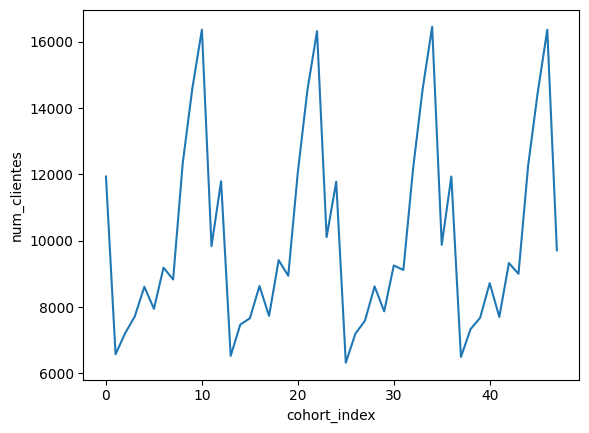

In [213]:
df_ = (
    df
    .groupby('cohort_index',as_index = False)
    ['id_del_cliente']
    .size()
    .rename(columns={'size':'num_clientes'})
)
sns.lineplot(
    data = df_,
    x = 'cohort_index',
    y = 'num_clientes'
)

### Agrupación por ciudad

In [214]:
cohortes_ciudad = (
    df
    .pivot_table(
        index = 'ciudad',
        columns = 'cohort_index',
        values = 'id_del_cliente',
        aggfunc = 'nunique'
    )
)
cohortes_ciudad = cohortes_ciudad.divide(cohortes_ciudad[0],axis=0)
cohortes_ciudad.head()

cohort_index,0,1,2,3,4,5,6,7,8,9,...,38,39,40,41,42,43,44,45,46,47
ciudad,,,,,,,,,,,,,,,,,,,,,
ALCALÁ DE HENARES,1.0,0.670732,0.707317,0.634146,0.719512,0.719512,0.670732,0.658537,0.780488,0.756098,...,0.695122,0.682927,0.756098,0.719512,0.670732,0.670732,0.792683,0.743902,0.731707,0.500000
ALICANTE,1.0,0.478261,0.608696,0.594203,0.579710,0.579710,0.594203,0.550725,0.637681,0.565217,...,0.579710,0.623188,0.536232,0.623188,0.579710,0.521739,0.637681,0.536232,0.565217,0.391304
AVILÉS,1.0,0.575342,0.671233,0.684932,0.643836,0.589041,0.630137,0.602740,0.767123,0.698630,...,0.712329,0.671233,0.671233,0.561644,0.657534,0.630137,0.739726,0.698630,0.616438,0.438356
BARCELONA,1.0,0.551282,0.653846,0.628205,0.602564,0.602564,0.641026,0.679487,0.679487,0.717949,...,0.641026,0.602564,0.576923,0.589744,0.628205,0.641026,0.666667,0.730769,0.666667,0.551282
CASTELLÓN,1.0,0.553191,0.563830,0.627660,0.606383,0.553191,0.595745,0.563830,0.638298,0.670213,...,0.553191,0.595745,0.585106,0.574468,0.627660,0.563830,0.638298,0.670213,0.606383,0.457447


<Axes: xlabel='cohort_index', ylabel='ciudad'>

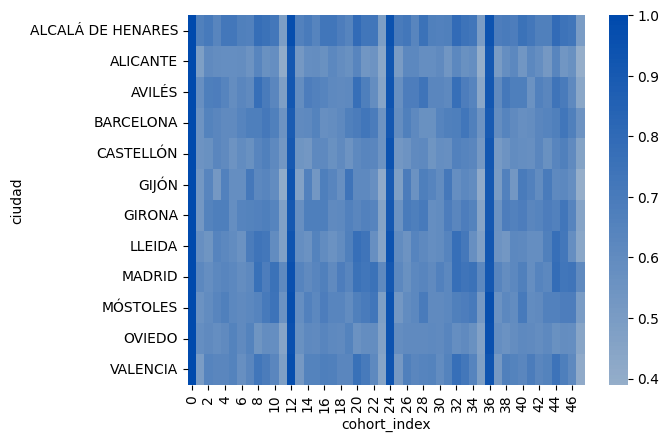

In [215]:
sns.heatmap(
    cohortes_ciudad,
    cmap = cmap,
    center = 0,
    vmax = 1
)

In [216]:
cohortes_ciudad = (
    df
    .pivot_table(
        index = 'ciudad',
        columns = 'cohort_index',
        aggfunc = 'size'
    )
)
cohortes_ciudad = cohortes_ciudad.divide(cohortes_ciudad.shift(axis=1))
cohortes_ciudad.head()

cohort_index,0,1,2,3,4,5,6,7,8,9,...,38,39,40,41,42,43,44,45,46,47
ciudad,,,,,,,,,,,,,,,,,,,,,
ALCALÁ DE HENARES,NaN,0.675841,0.942685,0.979200,1.346405,0.893204,0.918478,1.050296,1.977465,0.824786,...,0.833333,1.118644,1.248485,0.927184,0.883508,1.121481,1.844122,0.840258,1.326513,0.588689
ALICANTE,NaN,0.450067,1.804734,0.852459,0.928846,0.971014,1.130064,0.603774,2.021875,1.163833,...,2.184397,0.926948,0.840630,0.900000,1.319444,0.512281,2.304795,1.190193,0.942572,0.813245
AVILÉS,NaN,0.374355,1.234483,1.191806,1.200000,0.575521,1.027149,1.515419,1.040698,1.648045,...,1.195946,1.158192,1.188618,0.577291,1.113744,1.470213,0.953690,1.690440,1.063734,0.440506
BARCELONA,NaN,0.375546,1.295349,0.976661,1.211397,1.544765,0.675835,0.959302,1.593939,0.953422,...,1.237581,0.951134,1.155963,1.493651,0.751328,0.957567,1.555391,0.992403,1.413397,0.674340
CASTELLÓN,NaN,0.541880,0.861199,1.043956,1.378947,1.134860,0.818386,0.943836,1.325109,1.403067,...,0.906349,0.894921,1.479452,0.941799,1.088483,0.863226,1.257100,1.486326,1.212800,0.618734


<Axes: xlabel='cohort_index', ylabel='ciudad'>

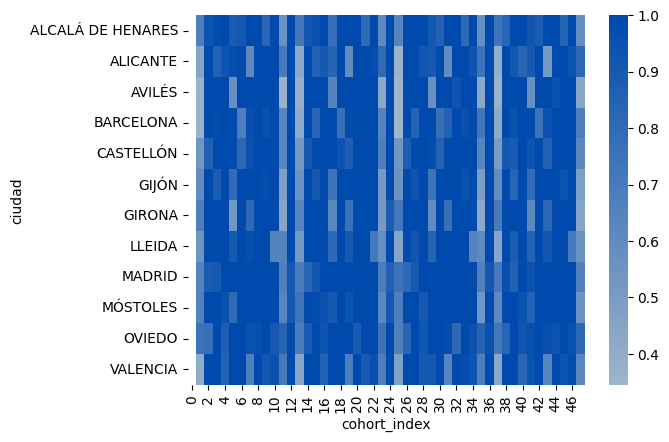

In [217]:
sns.heatmap(
    cohortes_ciudad,
    cmap = cmap,
    center = 0,
    vmax = 1
)

In [218]:
cohortes_ciudad = (
    df
    .pivot_table(
        index = 'ciudad',
        columns = 'cohort_index',
        values = 'total',
        aggfunc = 'mean'
    )
)
cohortes_ciudad = cohortes_ciudad.divide(cohortes_ciudad[0],axis=0)
cohortes_ciudad.head()

cohort_index,0,1,2,3,4,5,6,7,8,9,...,38,39,40,41,42,43,44,45,46,47
ciudad,,,,,,,,,,,,,,,,,,,,,
ALCALÁ DE HENARES,1.0,1.108172,1.211622,1.167909,1.168074,1.209607,1.237930,1.435317,1.168813,1.171292,...,1.245846,1.073519,1.103964,1.212425,1.200744,1.446906,1.146052,1.192850,1.110968,1.062655
ALICANTE,1.0,1.139996,1.006362,1.055474,1.151146,1.151058,1.102498,1.813702,1.405346,1.038483,...,0.950514,1.179529,1.134653,1.164031,1.145157,1.594166,1.425908,1.055759,1.209191,1.325650
AVILÉS,1.0,1.520702,1.359240,1.177168,1.348753,1.326937,1.330504,1.324194,1.628749,1.163536,...,1.370373,1.145610,1.358438,1.266897,1.334774,1.357702,1.367076,1.281991,1.310200,1.312976
BARCELONA,1.0,1.063695,1.095900,1.271752,1.454860,1.134349,1.008653,1.326966,1.014574,1.327674,...,1.085211,1.172759,1.306195,0.963833,0.971451,1.346516,1.061240,1.294064,1.014849,1.144489
CASTELLÓN,1.0,0.978122,0.856563,0.989193,0.885045,1.063305,1.011025,1.122592,0.921225,1.021815,...,0.909529,0.914830,0.836544,1.053600,1.035626,1.030246,0.921526,0.999115,0.850469,0.929675


<Axes: xlabel='cohort_index', ylabel='ciudad'>

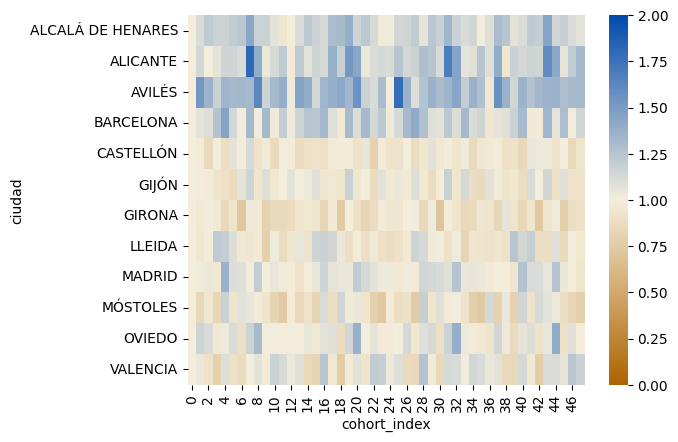

In [219]:
sns.heatmap(
    cohortes_ciudad,
    cmap = cmap,
    center = 1,
    vmax = 2,
    vmin = 0
)